In [1]:
!pip install shap


In [2]:
# =====================================
# ENHANCED POLLUTION PREDICTION MODEL
# Focus: LightGBM, XGBoost, Random Forest
# Features: SHAP Analysis, Advanced Feature Engineering, Stacking Ensemble
# =====================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, KFold
from sklearn.preprocessing import RobustScaler, PowerTransformer, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.cluster import DBSCAN
import lightgbm as lgb
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
import shap
import warnings
import joblib
import os
from scipy import stats
from scipy.stats import boxcox, yeojohnson
import gc

warnings.filterwarnings('ignore')

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)
os.makedirs('results', exist_ok=True)

print("Enhanced Pollution Prediction Model - Three Core Models Focus")
print("=" * 80)

Enhanced Pollution Prediction Model - Three Core Models Focus


In [3]:
# =====================================
# 1. COMPREHENSIVE IMPORTS AND SETUP
# =====================================

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
import json
import joblib
from scipy import stats
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import (
    train_test_split, TimeSeriesSplit, cross_val_score, 
    StratifiedKFold, KFold
)
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    explained_variance_score, median_absolute_error
)
from sklearn.feature_selection import (
    SelectKBest, f_regression, RFE, SelectFromModel,
    mutual_info_regression, chi2
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import PolynomialFeatures

# Tree-based models
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, 
    ExtraTreesRegressor, AdaBoostRegressor,
    VotingRegressor, StackingRegressor, BaggingRegressor
)
from sklearn.tree import DecisionTreeRegressor

# Linear models
from sklearn.linear_model import (
    ElasticNet, Ridge, Lasso, HuberRegressor,
    LinearRegression, SGDRegressor, BayesianRidge
)

# SVR and neighbors
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Gradient boosting libraries
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Hyperparameter optimization
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Set seeds for reproducibility
np.random.seed(42)

# Create directory structure
directories = [
    'models', 'models/individual', 'models/ensembles',
    'results', 'submissions', 'plots', 'optuna_studies', 
    'feature_importance', 'logs'
]

for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"✅ Created directory: {directory}")

print("🚀 Advanced Air Pollution Prediction Model - Setup Complete!")
print(f"📅 Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)

🚀 Advanced Air Pollution Prediction Model - Setup Complete!
📅 Started at: 2025-08-26 18:19:44


In [4]:
# =====================================
# ADVANCED FEATURE ENGINEERING V2
# =====================================

def create_advanced_features_v2(df, is_train=True):
    """
    Advanced feature engineering focusing on spatial, temporal, and interaction features
    """
    df_adv = df.copy()
    
    print(f"Creating advanced features v2... Initial shape: {df_adv.shape}")
    
    # Preserve target column if it exists (for training data)
    target_col = None
    if 'pollution_value' in df_adv.columns:
        target_col = df_adv['pollution_value'].copy()
        print("Pollution_value target column preserved for feature engineering")
    
    # First, handle any missing values in the dataframe
    print("Handling missing values...")
    initial_nan_count = df_adv.isnull().sum().sum()
    if initial_nan_count > 0:
        print(f"Found {initial_nan_count} NaN values, filling with appropriate values...")
        
        # Fill numerical columns with median (excluding pollution_value)
        numerical_cols = df_adv.select_dtypes(include=[np.number]).columns
        numerical_cols = [col for col in numerical_cols if col != 'pollution_value']
        for col in numerical_cols:
            if df_adv[col].isnull().any():
                df_adv[col].fillna(df_adv[col].median(), inplace=True)
        
        # Fill categorical columns with mode
        categorical_cols = df_adv.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if df_adv[col].isnull().any():
                df_adv[col].fillna(df_adv[col].mode()[0] if len(df_adv[col].mode()) > 0 else 'unknown', inplace=True)
    
    # 1. POLYNOMIAL INTERACTIONS of key features
    key_features = ['latitude', 'longitude', 'hour']
    # Check if these features exist and have no NaN values
    available_key_features = [f for f in key_features if f in df_adv.columns]
    
    if len(available_key_features) >= 2:
        print(f"Creating polynomial features from: {available_key_features}")
        
        # Ensure no NaN values in key features
        for feature in available_key_features:
            if df_adv[feature].isnull().any():
                df_adv[feature].fillna(df_adv[feature].median(), inplace=True)
        
        # Check for any infinite values
        for feature in available_key_features:
            df_adv[feature] = df_adv[feature].replace([np.inf, -np.inf], df_adv[feature].median())
        
        poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        poly_features = poly.fit_transform(df_adv[available_key_features])
        poly_feature_names = poly.get_feature_names_out(available_key_features)
        
        for i, name in enumerate(poly_feature_names):
            if name not in available_key_features:
                df_adv[f'poly_{name}'] = poly_features[:, i]
        
        print(f"Added {len(poly_feature_names) - len(available_key_features)} polynomial interaction features")
    else:
        print(f"Skipping polynomial features - only {len(available_key_features)} key features available")
    
    # 2. SPATIAL CLUSTERING
    if 'latitude' in df_adv.columns and 'longitude' in df_adv.columns:
        coords = df_adv[['latitude', 'longitude']].values
        
        # DBSCAN clustering
        dbscan = DBSCAN(eps=0.05, min_samples=20)
        clusters = dbscan.fit_predict(coords)
        df_adv['spatial_cluster'] = clusters
        
        # Distance to major cluster centers
        unique_clusters = np.unique(clusters[clusters != -1])
        for cluster_id in unique_clusters[:3]:
            cluster_points = coords[clusters == cluster_id]
            if len(cluster_points) > 0:
                cluster_center = np.mean(cluster_points, axis=0)
                distances = np.sqrt(np.sum((coords - cluster_center)**2, axis=1))
                df_adv[f'dist_cluster_{cluster_id}'] = distances
    
    # 3. ENHANCED CYCLICAL FEATURES
    time_features = {
        'hour': 24,
        'day_of_week': 7,
        'day_of_year': 365.25,
        'month': 12
    }
    
    for feature, period in time_features.items():
        if feature in df_adv.columns:
            # Multiple harmonics
            for harmonic in [1, 2, 3]:
                df_adv[f'{feature}_sin_h{harmonic}'] = np.sin(2 * np.pi * harmonic * df_adv[feature] / period)
                df_adv[f'{feature}_cos_h{harmonic}'] = np.cos(2 * np.pi * harmonic * df_adv[feature] / period)
    
    # 4. STATISTICAL AGGREGATIONS
    if 'latitude' in df_adv.columns and 'longitude' in df_adv.columns:
        # Spatial binning
        df_adv['lat_bin'] = pd.cut(df_adv['latitude'], bins=15, labels=False)
        df_adv['lon_bin'] = pd.cut(df_adv['longitude'], bins=15, labels=False)
        
        # Combined spatial bin
        df_adv['spatial_bin'] = df_adv['lat_bin'] * 100 + df_adv['lon_bin']
    
    # 5. DISTANCE-BASED FEATURES
    if 'latitude' in df_adv.columns and 'longitude' in df_adv.columns:
        lat_center = df_adv['latitude'].mean()
        lon_center = df_adv['longitude'].mean()
        
        df_adv['distance_from_center'] = np.sqrt(
            (df_adv['latitude'] - lat_center)**2 + 
            (df_adv['longitude'] - lon_center)**2
        )
        
        # Distance from boundaries
        df_adv['dist_from_lat_min'] = df_adv['latitude'] - df_adv['latitude'].min()
        df_adv['dist_from_lat_max'] = df_adv['latitude'].max() - df_adv['latitude']
        df_adv['dist_from_lon_min'] = df_adv['longitude'] - df_adv['longitude'].min()
        df_adv['dist_from_lon_max'] = df_adv['longitude'].max() - df_adv['longitude']
    
    # 6. TEMPORAL PATTERNS
    if 'hour' in df_adv.columns:
        # Rush hour indicators
        df_adv['is_morning_rush'] = ((df_adv['hour'] >= 7) & (df_adv['hour'] <= 9)).astype(int)
        df_adv['is_evening_rush'] = ((df_adv['hour'] >= 17) & (df_adv['hour'] <= 19)).astype(int)
        df_adv['is_rush_hour'] = (df_adv['is_morning_rush'] | df_adv['is_evening_rush']).astype(int)
        
        # Time of day categories
        df_adv['time_category'] = pd.cut(df_adv['hour'], 
                                        bins=[0, 6, 12, 18, 24], 
                                        labels=['night', 'morning', 'afternoon', 'evening'],
                                        include_lowest=True)
        df_adv['time_category_encoded'] = pd.Categorical(df_adv['time_category']).codes
    
    if 'day_of_week' in df_adv.columns:
        df_adv['is_weekend'] = (df_adv['day_of_week'] >= 5).astype(int)
        
        if 'hour' in df_adv.columns:
            df_adv['weekend_hour_interaction'] = df_adv['is_weekend'] * df_adv['hour']
    
    # 7. WEATHER PROXY FEATURES
    if all(col in df_adv.columns for col in ['latitude', 'longitude', 'day_of_year']):
        # Simple weather proxies
        df_adv['weather_proxy'] = (
            np.sin(2*np.pi*df_adv['day_of_year']/365) * df_adv['latitude'] + 
            np.cos(2*np.pi*df_adv['day_of_year']/365) * df_adv['longitude']
        )
        
        # Temperature proxy
        df_adv['temp_proxy'] = (
            20 + 15 * np.sin(2*np.pi*(df_adv['day_of_year']-80)/365) +
            5 * np.sin(2*np.pi*df_adv['hour']/24) -
            0.1 * np.abs(df_adv['latitude'])
        )
    
    # 8. INTERACTION FEATURES
    numeric_cols = df_adv.select_dtypes(include=[np.number]).columns
    important_pairs = [
        ('latitude', 'longitude'),
        ('latitude', 'hour'),
        ('longitude', 'hour')
    ]
    
    for col1, col2 in important_pairs:
        if col1 in numeric_cols and col2 in numeric_cols:
            df_adv[f'{col1}_{col2}_interaction'] = df_adv[col1] * df_adv[col2]
            df_adv[f'{col1}_{col2}_ratio'] = df_adv[col1] / (df_adv[col2] + 1e-8)
    
    # 9. STATISTICAL FEATURES
    if len(numeric_cols) > 3:
        # Create some statistical aggregations across features
        df_adv['feature_mean'] = df_adv[numeric_cols[:5]].mean(axis=1)
        df_adv['feature_std'] = df_adv[numeric_cols[:5]].std(axis=1)
        df_adv['feature_median'] = df_adv[numeric_cols[:5]].median(axis=1)
    
    # Clean up categorical columns that can't be used directly
    df_adv = df_adv.drop(columns=['time_category'], errors='ignore')
    
    # Comprehensive NaN and infinite value handling
    print("Final cleanup: handling NaN and infinite values...")
    
    # Count initial problems
    initial_nan = df_adv.isnull().sum().sum()
    initial_inf = np.isinf(df_adv.select_dtypes(include=[np.number])).sum().sum()
    
    if initial_nan > 0:
        print(f"Cleaning {initial_nan} NaN values...")
        # Fill NaN with appropriate values
        numeric_columns = df_adv.select_dtypes(include=[np.number]).columns
        for col in numeric_columns:
            if df_adv[col].isnull().any():
                # Use median for numeric columns
                median_val = df_adv[col].median()
                if pd.isna(median_val):
                    df_adv[col].fillna(0, inplace=True)
                else:
                    df_adv[col].fillna(median_val, inplace=True)
        
        # Fill any remaining NaN with 0
        df_adv = df_adv.fillna(0)
    
    if initial_inf > 0:
        print(f"Cleaning {initial_inf} infinite values...")
        # Replace infinite values
        numeric_columns = df_adv.select_dtypes(include=[np.number]).columns
        for col in numeric_columns:
            if np.isinf(df_adv[col]).any():
                # Replace inf with column median, or 0 if median is also inf/nan
                median_val = df_adv[col].replace([np.inf, -np.inf], np.nan).median()
                if pd.isna(median_val):
                    df_adv[col] = df_adv[col].replace([np.inf, -np.inf], 0)
                else:
                    df_adv[col] = df_adv[col].replace([np.inf, -np.inf], median_val)
    
    # Final verification
    final_nan = df_adv.isnull().sum().sum()
    final_inf = np.isinf(df_adv.select_dtypes(include=[np.number])).sum().sum()
    
    if final_nan > 0 or final_inf > 0:
        print(f"Warning: Still have {final_nan} NaN and {final_inf} infinite values")
        # Last resort: fill everything with 0
        df_adv = df_adv.fillna(0)
        numeric_columns = df_adv.select_dtypes(include=[np.number]).columns
        df_adv[numeric_columns] = df_adv[numeric_columns].replace([np.inf, -np.inf], 0)
    
    # Restore target column if it was preserved
    if target_col is not None:
        df_adv['pollution_value'] = target_col
        print("Pollution_value target column restored after feature engineering")
    
    print(f"Advanced features v2 completed. Final shape: {df_adv.shape}")
    print(f"Added {df_adv.shape[1] - df.shape[1]} new features")
    print(f"Data quality: {df_adv.isnull().sum().sum()} NaN, {np.isinf(df_adv.select_dtypes(include=[np.number])).sum().sum()} infinite values")
    
    return df_adv

# Load and enhance data
print("Loading and enhancing training data...")
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Original train shape: {train_df.shape}")
print(f"Original test shape: {test_df.shape}")

# Data quality check
print("\nData Quality Check:")
print(f"Train NaN values: {train_df.isnull().sum().sum()}")
print(f"Test NaN values: {test_df.isnull().sum().sum()}")

# Check for infinite values in numeric columns
train_numeric = train_df.select_dtypes(include=[np.number])
test_numeric = test_df.select_dtypes(include=[np.number])
print(f"Train infinite values: {np.isinf(train_numeric).sum().sum()}")
print(f"Test infinite values: {np.isinf(test_numeric).sum().sum()}")

# Show columns with missing values
train_missing = train_df.isnull().sum()
test_missing = test_df.isnull().sum()
if train_missing.sum() > 0:
    print("Train columns with missing values:")
    print(train_missing[train_missing > 0])
if test_missing.sum() > 0:
    print("Test columns with missing values:")
    print(test_missing[test_missing > 0])

# Apply advanced feature engineering
train_enhanced = create_advanced_features_v2(train_df, is_train=True)
test_enhanced = create_advanced_features_v2(test_df, is_train=False)

print(f"Enhanced train shape: {train_enhanced.shape}")
print(f"Enhanced test shape: {test_enhanced.shape}")

# Post-feature engineering data quality check
print("\nPost-Feature Engineering Quality Check:")

# Check if target column exists
print(f"Columns in train_enhanced: {list(train_enhanced.columns)}")
print(f"Columns in test_enhanced: {list(test_enhanced.columns)}")

if 'pollution_value' not in train_enhanced.columns:
    print("ERROR: pollution_value column missing from train_enhanced!")
    print("Available columns:", train_enhanced.columns.tolist())
    
    # Try to restore target from original data
    if 'train_df' in locals() and 'pollution_value' in train_df.columns:
        print("Restoring pollution_value column from original training data...")
        train_enhanced['pollution_value'] = train_df['pollution_value']
        print("Pollution_value column successfully restored!")
    else:
        raise KeyError("pollution_value column missing and cannot be restored from original data")

print(f"Train enhanced NaN values: {train_enhanced.isnull().sum().sum()}")
print(f"Test enhanced NaN values: {test_enhanced.isnull().sum().sum()}")

train_enhanced_numeric = train_enhanced.select_dtypes(include=[np.number])
test_enhanced_numeric = test_enhanced.select_dtypes(include=[np.number])
print(f"Train enhanced infinite values: {np.isinf(train_enhanced_numeric).sum().sum()}")
print(f"Test enhanced infinite values: {np.isinf(test_enhanced_numeric).sum().sum()}")

# Align features between train and test
train_features = set(train_enhanced.columns) - {'pollution_value'}
test_features = set(test_enhanced.columns) - {'id'}
common_features = list(train_features.intersection(test_features))

print(f"Common features: {len(common_features)}")

# Prepare final datasets
X = train_enhanced[common_features]
y = train_enhanced['pollution_value']
X_test = test_enhanced[common_features]
test_ids = test_enhanced['id']

# Final data quality check on X and X_test
print(f"\nFinal Dataset Quality Check:")
print(f"X NaN values: {X.isnull().sum().sum()}")
print(f"X_test NaN values: {X_test.isnull().sum().sum()}")
print(f"X infinite values: {np.isinf(X).sum().sum()}")
print(f"X_test infinite values: {np.isinf(X_test).sum().sum()}")

# If there are still issues, fix them
if X.isnull().sum().sum() > 0 or X_test.isnull().sum().sum() > 0:
    print("Fixing remaining NaN values...")
    X = X.fillna(0)
    X_test = X_test.fillna(0)

if np.isinf(X).sum().sum() > 0 or np.isinf(X_test).sum().sum() > 0:
    print("Fixing remaining infinite values...")
    X = X.replace([np.inf, -np.inf], 0)
    X_test = X_test.replace([np.inf, -np.inf], 0)

print(f"Final X shape: {X.shape}")
print(f"Final X_test shape: {X_test.shape}")
print("Advanced feature engineering completed!")

Loading and enhancing training data...
Original train shape: (7649, 8)
Original test shape: (2739, 7)

Data Quality Check:
Train NaN values: 26
Test NaN values: 0
Train infinite values: 0
Test infinite values: 0
Train columns with missing values:
latitude     13
longitude    13
dtype: int64
Creating advanced features v2... Initial shape: (7649, 8)
Pollution_value target column preserved for feature engineering
Handling missing values...
Found 26 NaN values, filling with appropriate values...
Creating polynomial features from: ['latitude', 'longitude', 'hour']
Added 3 polynomial interaction features
Final cleanup: handling NaN and infinite values...
Pollution_value target column restored after feature engineering
Advanced features v2 completed. Final shape: (7649, 64)
Added 56 new features
Data quality: 0 NaN, 0 infinite values
Creating advanced features v2... Initial shape: (2739, 7)
Handling missing values...
Creating polynomial features from: ['latitude', 'longitude', 'hour']
Added 3

Analyzing target variable distribution and heteroscedasticity...

Best transformation: Box-Cox (skewness: -0.016)

Best transformation: Box-Cox (skewness: -0.016)


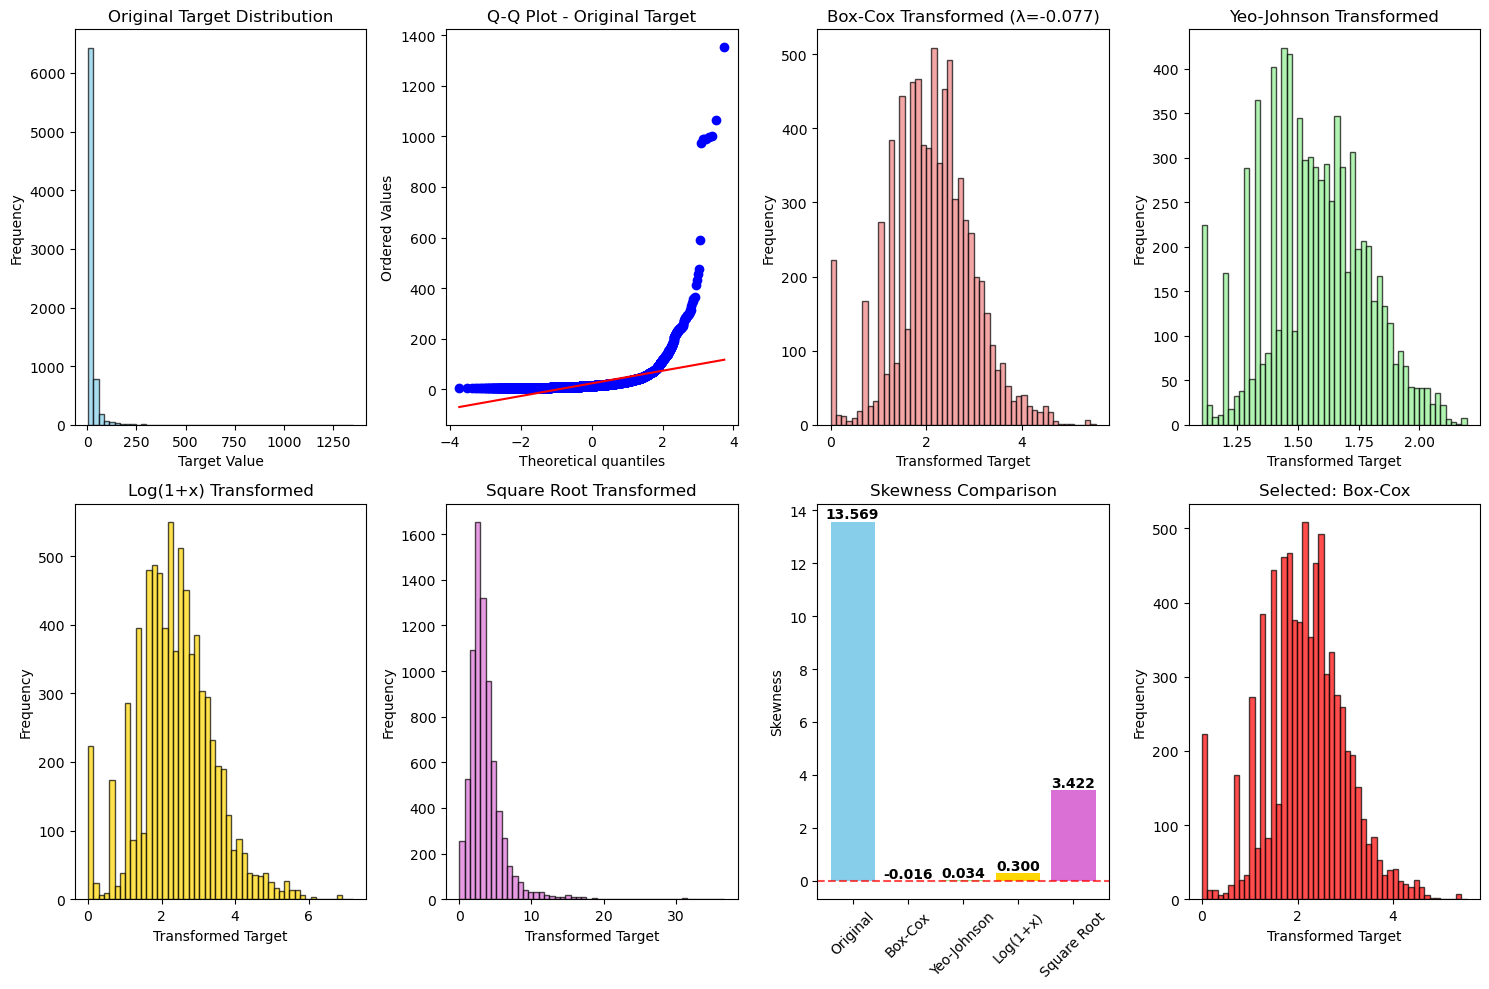

Target transformation applied: Box-Cox
Original target range: [3.500, 1352.800]
Transformed target range: [0.000, 5.536]


In [5]:
# =====================================
# HETEROSCEDASTICITY ANALYSIS & TARGET TRANSFORMATION
# =====================================

# Analyze target distribution and heteroscedasticity
print("Analyzing target variable distribution and heteroscedasticity...")

plt.figure(figsize=(15, 10))

# Original target distribution
plt.subplot(2, 4, 1)
plt.hist(y, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Original Target Distribution')
plt.xlabel('Target Value')
plt.ylabel('Frequency')

# Q-Q plot for normality
plt.subplot(2, 4, 2)
stats.probplot(y, dist="norm", plot=plt)
plt.title('Q-Q Plot - Original Target')

# Box-Cox transformation
y_positive = y - y.min() + 1  # Make all values positive
y_boxcox, lambda_boxcox = boxcox(y_positive)

plt.subplot(2, 4, 3)
plt.hist(y_boxcox, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title(f'Box-Cox Transformed (λ={lambda_boxcox:.3f})')
plt.xlabel('Transformed Target')
plt.ylabel('Frequency')

# Yeo-Johnson transformation (handles negative values)
transformer_yj = PowerTransformer(method='yeo-johnson', standardize=False)
y_yeojohnson = transformer_yj.fit_transform(y.values.reshape(-1, 1)).flatten()

plt.subplot(2, 4, 4)
plt.hist(y_yeojohnson, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Yeo-Johnson Transformed')
plt.xlabel('Transformed Target')
plt.ylabel('Frequency')

# Log transformation (for positive values)
y_log = np.log1p(y - y.min())  # log(1 + x) transformation

plt.subplot(2, 4, 5)
plt.hist(y_log, bins=50, alpha=0.7, color='gold', edgecolor='black')
plt.title('Log(1+x) Transformed')
plt.xlabel('Transformed Target')
plt.ylabel('Frequency')

# Square root transformation
y_sqrt = np.sqrt(y - y.min())

plt.subplot(2, 4, 6)
plt.hist(y_sqrt, bins=50, alpha=0.7, color='orchid', edgecolor='black')
plt.title('Square Root Transformed')
plt.xlabel('Transformed Target')
plt.ylabel('Frequency')

# Compare skewness
transformations = {
    'Original': y,
    'Box-Cox': y_boxcox,
    'Yeo-Johnson': y_yeojohnson,
    'Log(1+x)': y_log,
    'Square Root': y_sqrt
}

skewness_results = {}
for name, data in transformations.items():
    skewness_results[name] = stats.skew(data)

plt.subplot(2, 4, 7)
names = list(skewness_results.keys())
skew_values = list(skewness_results.values())
bars = plt.bar(names, skew_values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'orchid'])
plt.title('Skewness Comparison')
plt.ylabel('Skewness')
plt.xticks(rotation=45)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)

# Add value labels on bars
for bar, value in zip(bars, skew_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Choose best transformation (lowest absolute skewness)
best_transform = min(skewness_results, key=lambda x: abs(skewness_results[x]))
print(f"\nBest transformation: {best_transform} (skewness: {skewness_results[best_transform]:.3f})")

# Apply best transformation
if best_transform == 'Box-Cox':
    y_transformed = y_boxcox
    transform_func = lambda x: boxcox(x - x.min() + 1, lambda_boxcox)
    inverse_func = lambda x: (np.power(x * lambda_boxcox + 1, 1/lambda_boxcox) - 1) + y.min()
elif best_transform == 'Yeo-Johnson':
    y_transformed = y_yeojohnson
    transform_func = lambda x: transformer_yj.transform(x.values.reshape(-1, 1)).flatten()
    inverse_func = lambda x: transformer_yj.inverse_transform(x.reshape(-1, 1)).flatten()
elif best_transform == 'Log(1+x)':
    y_transformed = y_log
    transform_func = lambda x: np.log1p(x - x.min())
    inverse_func = lambda x: np.expm1(x) + y.min()
elif best_transform == 'Square Root':
    y_transformed = y_sqrt
    transform_func = lambda x: np.sqrt(x - x.min())
    inverse_func = lambda x: np.power(x, 2) + y.min()
else:
    y_transformed = y
    transform_func = lambda x: x
    inverse_func = lambda x: x

plt.subplot(2, 4, 8)
plt.hist(y_transformed, bins=50, alpha=0.7, color='red', edgecolor='black')
plt.title(f'Selected: {best_transform}')
plt.xlabel('Transformed Target')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('plots/heteroscedasticity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Target transformation applied: {best_transform}")
print(f"Original target range: [{y.min():.3f}, {y.max():.3f}]")
print(f"Transformed target range: [{y_transformed.min():.3f}, {y_transformed.max():.3f}]")

Setting up enhanced cross-validation strategy...
Train set: (6119, 59)
Validation set: (1530, 59)
Test set: (2739, 59)
Cross-validation strategies prepared:
  - KFold: 5 splits
  - TimeSeriesSplit: 5 splits
  - Stratified_KFold: 5 splits
Data scaling completed using RobustScaler
Feature scaling - Train mean: 187339.067424, std: 24457160.704449
Computing feature importance using mutual information...
Top 10 most important features:
                       feature  importance
21           dist_from_lon_min    0.591918
2                    longitude    0.591790
39           dist_from_lon_max    0.591637
20                 spatial_bin    0.545337
30              feature_median    0.523412
23  longitude_hour_interaction    0.518860
35         poly_longitude hour    0.518356
47        distance_from_center    0.517285
18                 day_of_year    0.510638
7                weather_proxy    0.493448
Top 10 most important features:
                       feature  importance
21           dist

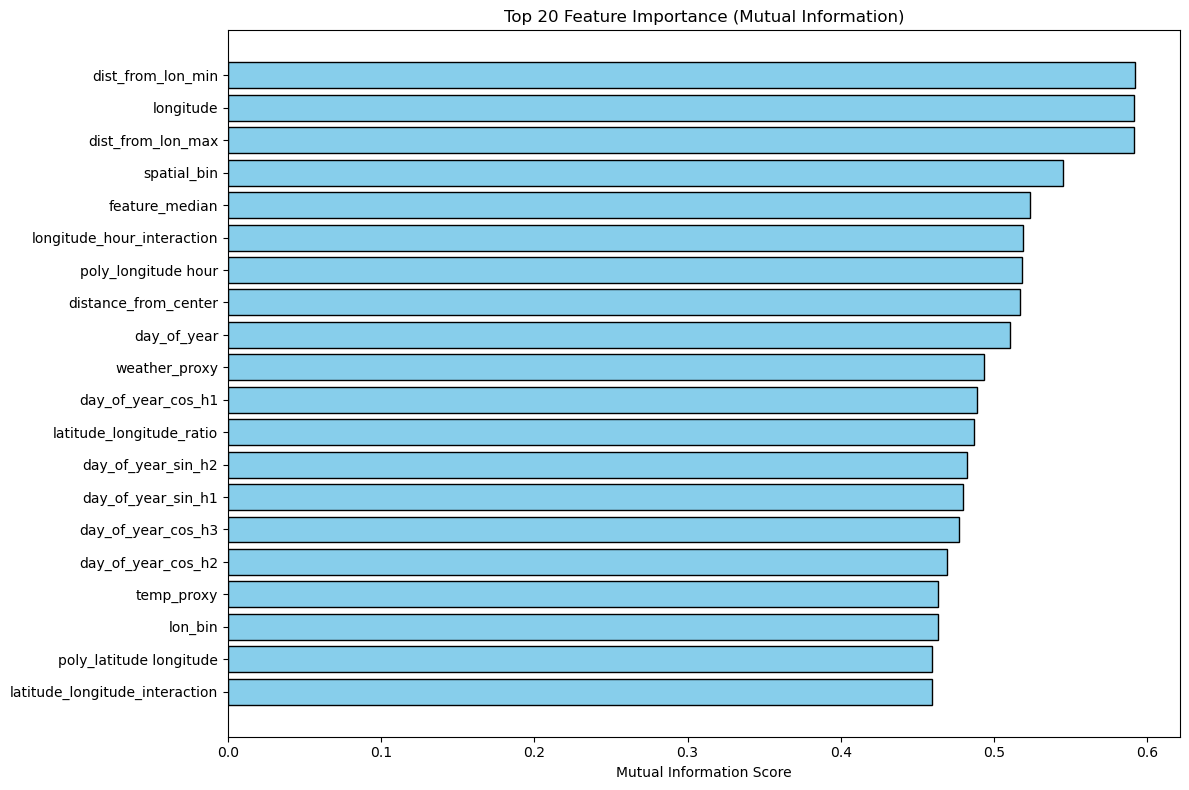

Enhanced cross-validation setup completed!


In [6]:
# =====================================
# ENHANCED CROSS-VALIDATION SETUP
# =====================================

print("Setting up enhanced cross-validation strategy...")

# Split data with stratification based on target quantiles
y_bins = pd.qcut(y_transformed, q=5, labels=False, duplicates='drop')

# Train-validation split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y_transformed, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_bins
)

print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Enhanced Cross-Validation Strategies
cv_strategies = {
    'KFold': KFold(n_splits=5, shuffle=True, random_state=42),
    'TimeSeriesSplit': TimeSeriesSplit(n_splits=5),
    'Stratified_KFold': KFold(n_splits=5, shuffle=True, random_state=42)  # We'll use y_bins for stratification
}

print("Cross-validation strategies prepared:")
for name, strategy in cv_strategies.items():
    print(f"  - {name}: {strategy.n_splits} splits")

# Robust Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Data scaling completed using RobustScaler")
print(f"Feature scaling - Train mean: {X_train_scaled.mean():.6f}, std: {X_train_scaled.std():.6f}")

# Feature importance analysis for initial insights
from sklearn.feature_selection import mutual_info_regression

print("Computing feature importance using mutual information...")
feature_importance = mutual_info_regression(X_train_scaled, y_train, random_state=42)
feature_names = X.columns

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"Top 10 most important features:")
print(feature_importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='skyblue', edgecolor='black')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Mutual Information Score')
plt.title('Top 20 Feature Importance (Mutual Information)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('plots/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Enhanced cross-validation setup completed!")

[I 2025-08-26 18:19:48,342] A new study created in memory with name: lightgbm_optimization


Starting hyperparameter optimization for LightGBM, XGBoost, and Random Forest...

Optimizing LIGHTGBM...
--------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-26 18:19:52,616] Trial 0 finished with value: 0.599921108908816 and parameters: {'num_leaves': 125, 'learning_rate': 0.2536999076681772, 'feature_fraction': 0.892797576724562, 'bagging_fraction': 0.8394633936788146, 'bagging_freq': 2, 'min_child_samples': 19, 'max_depth': 3, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088, 'n_estimators': 737}. Best is trial 0 with value: 0.599921108908816.
[I 2025-08-26 18:19:56,348] Trial 1 finished with value: 0.6155126607893986 and parameters: {'num_leaves': 25, 'learning_rate': 0.2708160864249968, 'feature_fraction': 0.9329770563201687, 'bagging_fraction': 0.6849356442713105, 'bagging_freq': 2, 'min_child_samples': 22, 'max_depth': 6, 'reg_alpha': 5.247564316322379, 'reg_lambda': 4.319450186421157, 'n_estimators': 362}. Best is trial 0 with value: 0.599921108908816.
[I 2025-08-26 18:19:56,348] Trial 1 finished with value: 0.6155126607893986 and parameters: {'num_leaves': 25, 'learning_rate': 0.2708160864249968, 'feature_

  File "c:\Users\damod\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\damod\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\damod\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\damod\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-26 18:35:05,711] A new study created in memory with name: xgboost_optimization



Optimizing XGBOOST...
--------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-26 18:35:06,607] Trial 0 finished with value: 0.623302033523319 and parameters: {'max_depth': 5, 'learning_rate': 0.2536999076681772, 'n_estimators': 759, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'colsample_bylevel': 0.662397808134481, 'reg_alpha': 0.5808361216819946, 'reg_lambda': 8.661761457749352, 'min_child_weight': 7, 'gamma': 7.080725777960454}. Best is trial 0 with value: 0.623302033523319.
[I 2025-08-26 18:35:07,489] Trial 1 finished with value: 0.6150366774471954 and parameters: {'max_depth': 3, 'learning_rate': 0.2708160864249968, 'n_estimators': 850, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'colsample_bylevel': 0.6733618039413735, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379, 'min_child_weight': 5, 'gamma': 2.9122914019804194}. Best is trial 1 with value: 0.6150366774471954.
[I 2025-08-26 18:35:07,489] Trial 1 finished with value: 0.6150366774471954 and parameters: {'max_depth': 3,

[I 2025-08-26 18:38:50,580] A new study created in memory with name: randomforest_optimization


Validation RMSE: 0.563988
Validation R²: 0.553740

Optimizing RANDOMFOREST...
--------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-26 18:38:52,487] Trial 0 finished with value: 0.5884092617744686 and parameters: {'n_estimators': 362, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.8540362888980227}. Best is trial 0 with value: 0.5884092617744686.
[I 2025-08-26 18:38:56,337] Trial 1 finished with value: 0.5818507751614557 and parameters: {'n_estimators': 114, 'max_depth': 49, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True, 'max_samples': 0.645614570099021}. Best is trial 1 with value: 0.5818507751614557.
[I 2025-08-26 18:38:56,337] Trial 1 finished with value: 0.5818507751614557 and parameters: {'n_estimators': 114, 'max_depth': 49, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True, 'max_samples': 0.645614570099021}. Best is trial 1 with value: 0.5818507751614557.
[I 2025-08-26 18:38:59,241] Trial 2 finished with value: 0.5827056538044724 and paramet

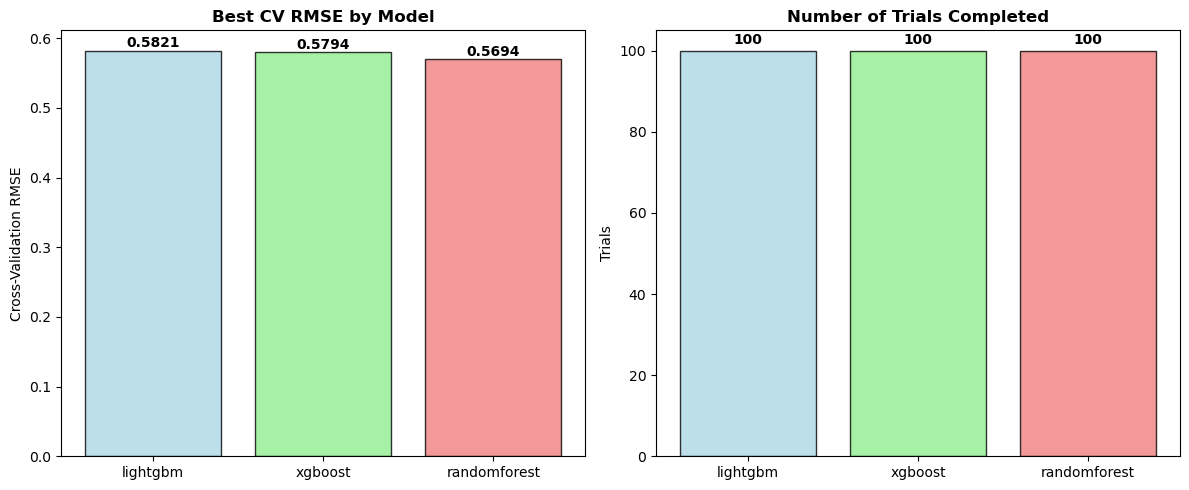

Hyperparameter optimization completed!


In [7]:
# =====================================
# HYPERPARAMETER OPTIMIZATION FOR THREE CORE MODELS
# =====================================

print("Starting hyperparameter optimization for LightGBM, XGBoost, and Random Forest...")
print("=" * 80)

# Store optimized models and results
optimized_models = {}
optimization_results = {}

def objective_lightgbm(trial):
    """Optimized LightGBM hyperparameters"""
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'random_state': 42,
        'verbose': -1,
        'n_jobs': -1
    }
    
    model = lgb.LGBMRegressor(**params)
    
    # Use KFold CV for robust evaluation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                               cv=cv_strategies['KFold'], 
                               scoring='neg_root_mean_squared_error', 
                               n_jobs=-1)
    return -cv_scores.mean()

def objective_xgboost(trial):
    """Optimized XGBoost hyperparameters"""
    params = {
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 10.0),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist'
    }
    
    model = xgb.XGBRegressor(**params)
    
    cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                               cv=cv_strategies['KFold'], 
                               scoring='neg_root_mean_squared_error', 
                               n_jobs=-1)
    return -cv_scores.mean()

def objective_randomforest(trial):
    """Optimized Random Forest hyperparameters"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'max_samples': trial.suggest_float('max_samples', 0.5, 1.0) if trial.params.get('bootstrap', True) else None,
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Remove max_samples if bootstrap is False
    if not params['bootstrap']:
        params.pop('max_samples', None)
    
    model = RandomForestRegressor(**params)
    
    cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                               cv=cv_strategies['KFold'], 
                               scoring='neg_root_mean_squared_error', 
                               n_jobs=-1)
    return -cv_scores.mean()

# Optimization parameters
N_TRIALS = 100
TIMEOUT = 1800  # 30 minutes per model

models_to_optimize = {
    'lightgbm': objective_lightgbm,
    'xgboost': objective_xgboost,
    'randomforest': objective_randomforest
}

# Run optimization for each model
for model_name, objective_func in models_to_optimize.items():
    print(f"\nOptimizing {model_name.upper()}...")
    print("-" * 50)
    
    study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=42),
        study_name=f'{model_name}_optimization'
    )
    
    study.optimize(objective_func, n_trials=N_TRIALS, timeout=TIMEOUT, show_progress_bar=True)
    
    # Store results
    optimization_results[model_name] = {
        'best_value': study.best_value,
        'best_params': study.best_params,
        'n_trials': len(study.trials)
    }
    
    print(f"Best {model_name} RMSE: {study.best_value:.6f}")
    print(f"Best parameters: {study.best_params}")
    print(f"Trials completed: {len(study.trials)}")
    
    # Train final model with best parameters
    if model_name == 'lightgbm':
        final_model = lgb.LGBMRegressor(**study.best_params)
    elif model_name == 'xgboost':
        final_model = xgb.XGBRegressor(**study.best_params)
    elif model_name == 'randomforest':
        final_model = RandomForestRegressor(**study.best_params)
    
    final_model.fit(X_train_scaled, y_train)
    optimized_models[model_name] = final_model
    
    # Validation predictions
    val_pred = final_model.predict(X_val_scaled)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    val_r2 = r2_score(y_val, val_pred)
    
    print(f"Validation RMSE: {val_rmse:.6f}")
    print(f"Validation R²: {val_r2:.6f}")
    
    # Save model
    joblib.dump(final_model, f'models/{model_name}_optimized.pkl')
    
    # Memory cleanup
    gc.collect()

# Summary of optimization results
print(f"\n{'='*80}")
print("HYPERPARAMETER OPTIMIZATION RESULTS")
print(f"{'='*80}")

results_df = pd.DataFrame(optimization_results).T
results_df = results_df.sort_values('best_value')
print(results_df)

# Visualize optimization results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
models = list(optimization_results.keys())
cv_scores = [optimization_results[m]['best_value'] for m in models]
bars = plt.bar(models, cv_scores, color=['lightblue', 'lightgreen', 'lightcoral'], 
               edgecolor='black', alpha=0.8)
plt.title('Best CV RMSE by Model', fontweight='bold')
plt.ylabel('Cross-Validation RMSE')
for bar, score in zip(bars, cv_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

plt.subplot(1, 2, 2)
trials = [optimization_results[m]['n_trials'] for m in models]
bars = plt.bar(models, trials, color=['lightblue', 'lightgreen', 'lightcoral'], 
               edgecolor='black', alpha=0.8)
plt.title('Number of Trials Completed', fontweight='bold')
plt.ylabel('Trials')
for bar, trial in zip(bars, trials):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{trial}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('plots/hyperparameter_optimization_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Hyperparameter optimization completed!")

Starting SHAP analysis for model interpretation...
Using 1000 samples for SHAP analysis

Analyzing LIGHTGBM with SHAP...
SHAP analysis completed for lightgbm

Analyzing XGBOOST with SHAP...
SHAP analysis completed for lightgbm

Analyzing XGBOOST with SHAP...
SHAP analysis completed for xgboost

Analyzing RANDOMFOREST with SHAP...
SHAP analysis completed for xgboost

Analyzing RANDOMFOREST with SHAP...
SHAP analysis completed for randomforest

Creating SHAP visualizations...
SHAP analysis completed for randomforest

Creating SHAP visualizations...


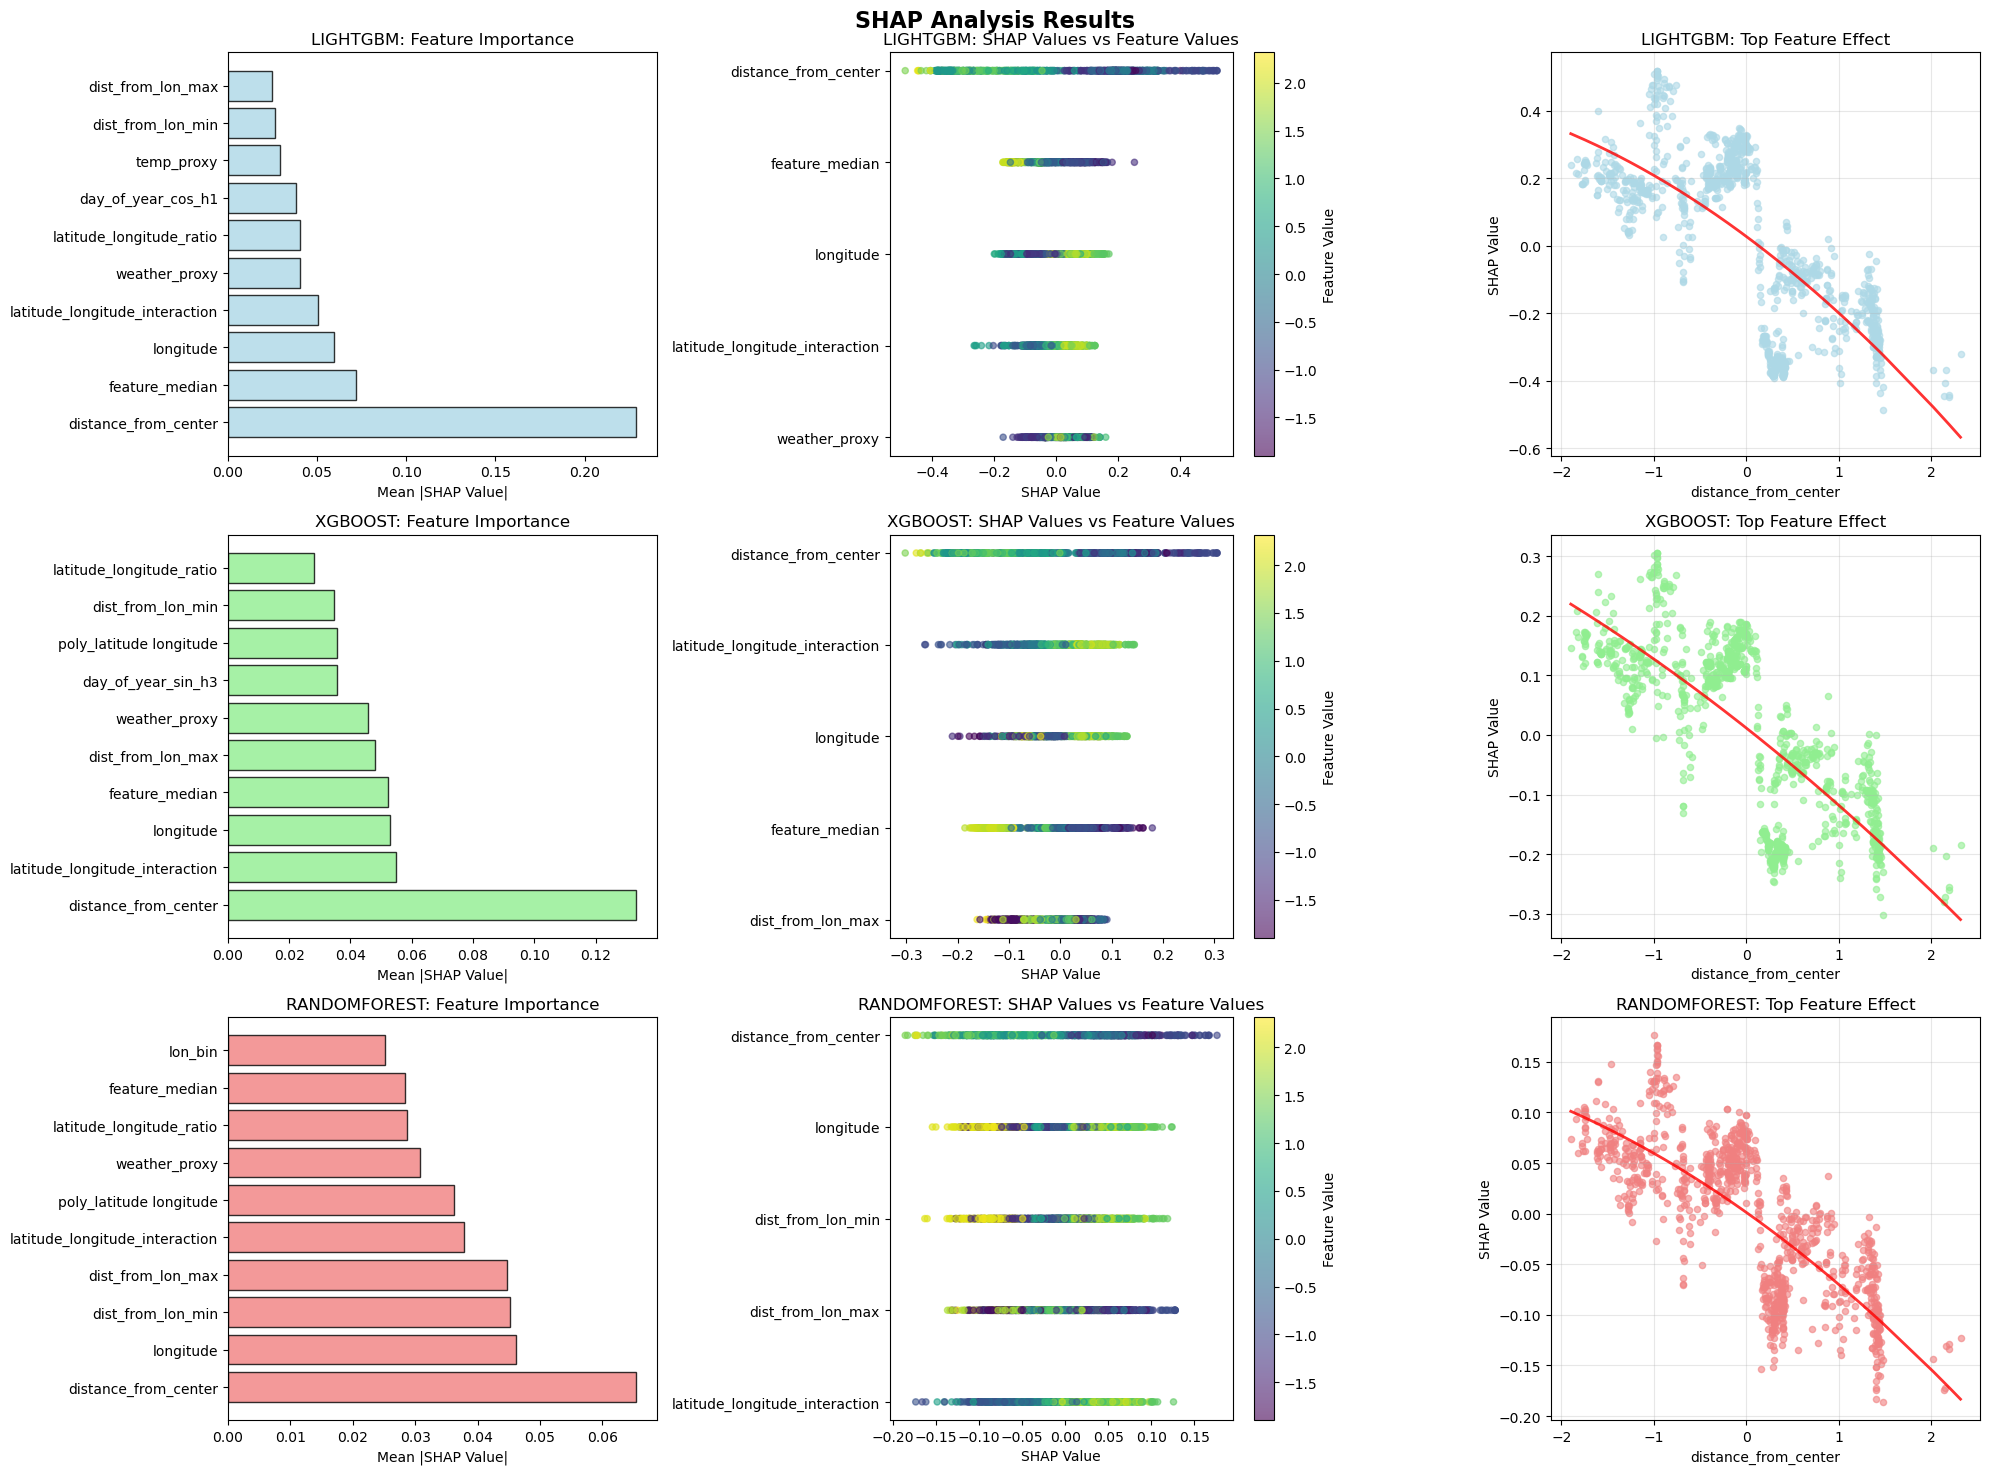


Comparing feature importance across models...


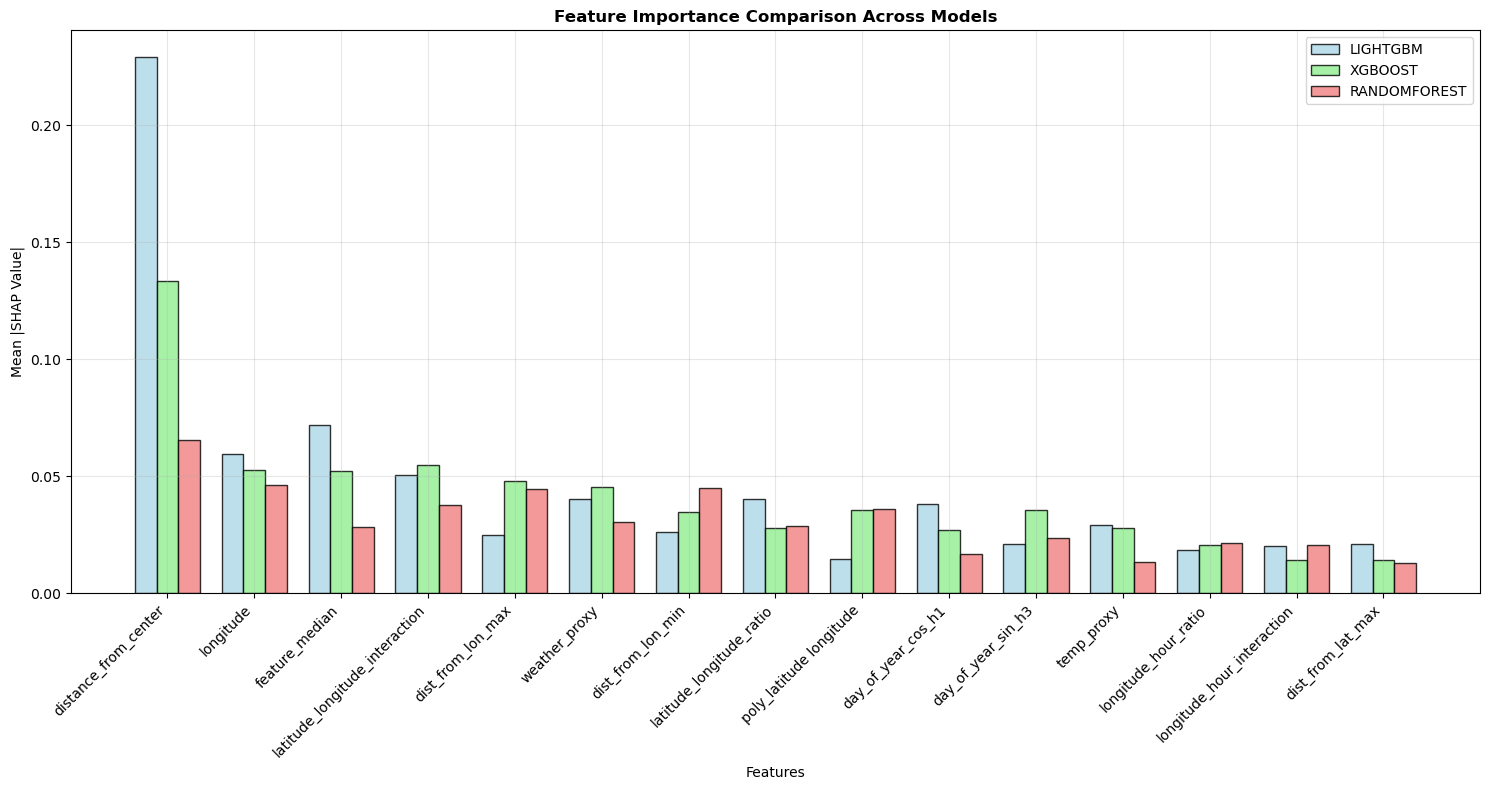


Saving SHAP results...
SHAP analysis completed and saved!

Top 5 most important features (average across models):
1. distance_from_center: 0.142579
2. longitude: 0.052802
3. feature_median: 0.050761
4. latitude_longitude_interaction: 0.047694
5. dist_from_lon_max: 0.039156


6200

In [8]:
# =====================================
# SHAP ANALYSIS FOR MODEL INTERPRETATION
# =====================================

print("Starting SHAP analysis for model interpretation...")
print("=" * 80)

# Initialize SHAP explainers for each model
shap_results = {}

# Sample subset for SHAP analysis (to speed up computation)
sample_size = min(1000, len(X_train_scaled))
sample_indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
X_sample = X_train_scaled[sample_indices]
y_sample = y_train[sample_indices]

print(f"Using {sample_size} samples for SHAP analysis")

# SHAP analysis for each model
for model_name, model in optimized_models.items():
    print(f"\nAnalyzing {model_name.upper()} with SHAP...")
    
    if model_name == 'lightgbm':
        # For LightGBM, use Tree explainer
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)
    elif model_name == 'xgboost':
        # For XGBoost, use Tree explainer
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)
    elif model_name == 'randomforest':
        # For Random Forest, use Tree explainer
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)
    
    shap_results[model_name] = {
        'explainer': explainer,
        'shap_values': shap_values,
        'sample_data': X_sample
    }
    
    print(f"SHAP analysis completed for {model_name}")

# Create comprehensive SHAP visualizations
print("\nCreating SHAP visualizations...")

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('SHAP Analysis Results', fontsize=16, fontweight='bold')

model_colors = ['lightblue', 'lightgreen', 'lightcoral']

for i, (model_name, results) in enumerate(shap_results.items()):
    shap_values = results['shap_values']
    sample_data = results['sample_data']
    
    # 1. Summary plot (bar)
    plt.subplot(3, 3, i*3 + 1)
    feature_importance = np.abs(shap_values).mean(0)
    top_features_idx = np.argsort(feature_importance)[-10:]
    
    plt.barh(range(len(top_features_idx)), feature_importance[top_features_idx], 
             color=model_colors[i], alpha=0.8, edgecolor='black')
    plt.yticks(range(len(top_features_idx)), 
               [feature_names[idx] for idx in top_features_idx])
    plt.xlabel('Mean |SHAP Value|')
    plt.title(f'{model_name.upper()}: Feature Importance')
    plt.gca().invert_yaxis()
    
    # 2. SHAP summary plot (beeswarm style - simplified)
    plt.subplot(3, 3, i*3 + 2)
    top_5_idx = np.argsort(feature_importance)[-5:]
    
    for j, feat_idx in enumerate(top_5_idx):
        shap_vals_feat = shap_values[:, feat_idx]
        feat_vals = sample_data[:, feat_idx]
        
        # Color points by feature value
        scatter = plt.scatter(shap_vals_feat, [j] * len(shap_vals_feat), 
                            c=feat_vals, alpha=0.6, s=20, cmap='viridis')
    
    plt.yticks(range(len(top_5_idx)), 
               [feature_names[idx] for idx in top_5_idx])
    plt.xlabel('SHAP Value')
    plt.title(f'{model_name.upper()}: SHAP Values vs Feature Values')
    plt.colorbar(scatter, ax=plt.gca(), label='Feature Value')
    
    # 3. Partial dependence for top feature
    plt.subplot(3, 3, i*3 + 3)
    top_feature_idx = np.argsort(feature_importance)[-1]
    top_feature_name = feature_names[top_feature_idx]
    
    # Sort by feature value for smooth line
    sort_idx = np.argsort(sample_data[:, top_feature_idx])
    sorted_feat_vals = sample_data[sort_idx, top_feature_idx]
    sorted_shap_vals = shap_values[sort_idx, top_feature_idx]
    
    plt.scatter(sorted_feat_vals, sorted_shap_vals, alpha=0.6, 
               color=model_colors[i], s=20)
    
    # Add trend line
    z = np.polyfit(sorted_feat_vals, sorted_shap_vals, 2)
    p = np.poly1d(z)
    plt.plot(sorted_feat_vals, p(sorted_feat_vals), 
             color='red', linewidth=2, alpha=0.8)
    
    plt.xlabel(f'{top_feature_name}')
    plt.ylabel('SHAP Value')
    plt.title(f'{model_name.upper()}: Top Feature Effect')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/shap_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature importance comparison across models
print("\nComparing feature importance across models...")

plt.figure(figsize=(15, 8))

# Get top 15 features by average importance across all models
all_importances = {}
for model_name, results in shap_results.items():
    feature_importance = np.abs(results['shap_values']).mean(0)
    for i, importance in enumerate(feature_importance):
        feat_name = feature_names[i]
        if feat_name not in all_importances:
            all_importances[feat_name] = {}
        all_importances[feat_name][model_name] = importance

# Calculate average importance
avg_importances = {feat: np.mean(list(importances.values())) 
                  for feat, importances in all_importances.items()}
top_features = sorted(avg_importances.keys(), key=lambda x: avg_importances[x], reverse=True)[:15]

# Create comparison plot
x = np.arange(len(top_features))
width = 0.25

for i, model_name in enumerate(shap_results.keys()):
    importances = [all_importances[feat].get(model_name, 0) for feat in top_features]
    plt.bar(x + i*width, importances, width, label=model_name.upper(), 
           color=model_colors[i], alpha=0.8, edgecolor='black')

plt.xlabel('Features')
plt.ylabel('Mean |SHAP Value|')
plt.title('Feature Importance Comparison Across Models', fontweight='bold')
plt.xticks(x + width, top_features, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save SHAP results
print("\nSaving SHAP results...")
shap_summary = {
    'top_features_by_model': {},
    'feature_importance_rankings': {}
}

for model_name, results in shap_results.items():
    feature_importance = np.abs(results['shap_values']).mean(0)
    top_features_idx = np.argsort(feature_importance)[-10:][::-1]
    
    shap_summary['top_features_by_model'][model_name] = [
        {
            'feature': feature_names[idx],
            'importance': feature_importance[idx]
        }
        for idx in top_features_idx
    ]

# Save to file
import json
with open('results/shap_analysis_summary.json', 'w') as f:
    json.dump(shap_summary, f, indent=2, default=str)

print("SHAP analysis completed and saved!")
print("\nTop 5 most important features (average across models):")
for i, feat in enumerate(top_features[:5], 1):
    avg_imp = avg_importances[feat]
    print(f"{i}. {feat}: {avg_imp:.6f}")

# Memory cleanup
del shap_values, sample_data
gc.collect()

Creating advanced stacking ensemble...
Base models for stacking ensemble:
  - LIGHTGBM
  - XGBOOST
  - RANDOMFOREST

Testing ridge meta-learner...
[LightGBM] [Warning] feature_fraction is set=0.7021784929474467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7021784929474467
[LightGBM] [Warning] bagging_fraction is set=0.9342587996581903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9342587996581903
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7021784929474467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7021784929474467
[LightGBM] [Warning] bagging_fraction is set=0.9342587996581903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9342587996581903
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Auto-choosing col

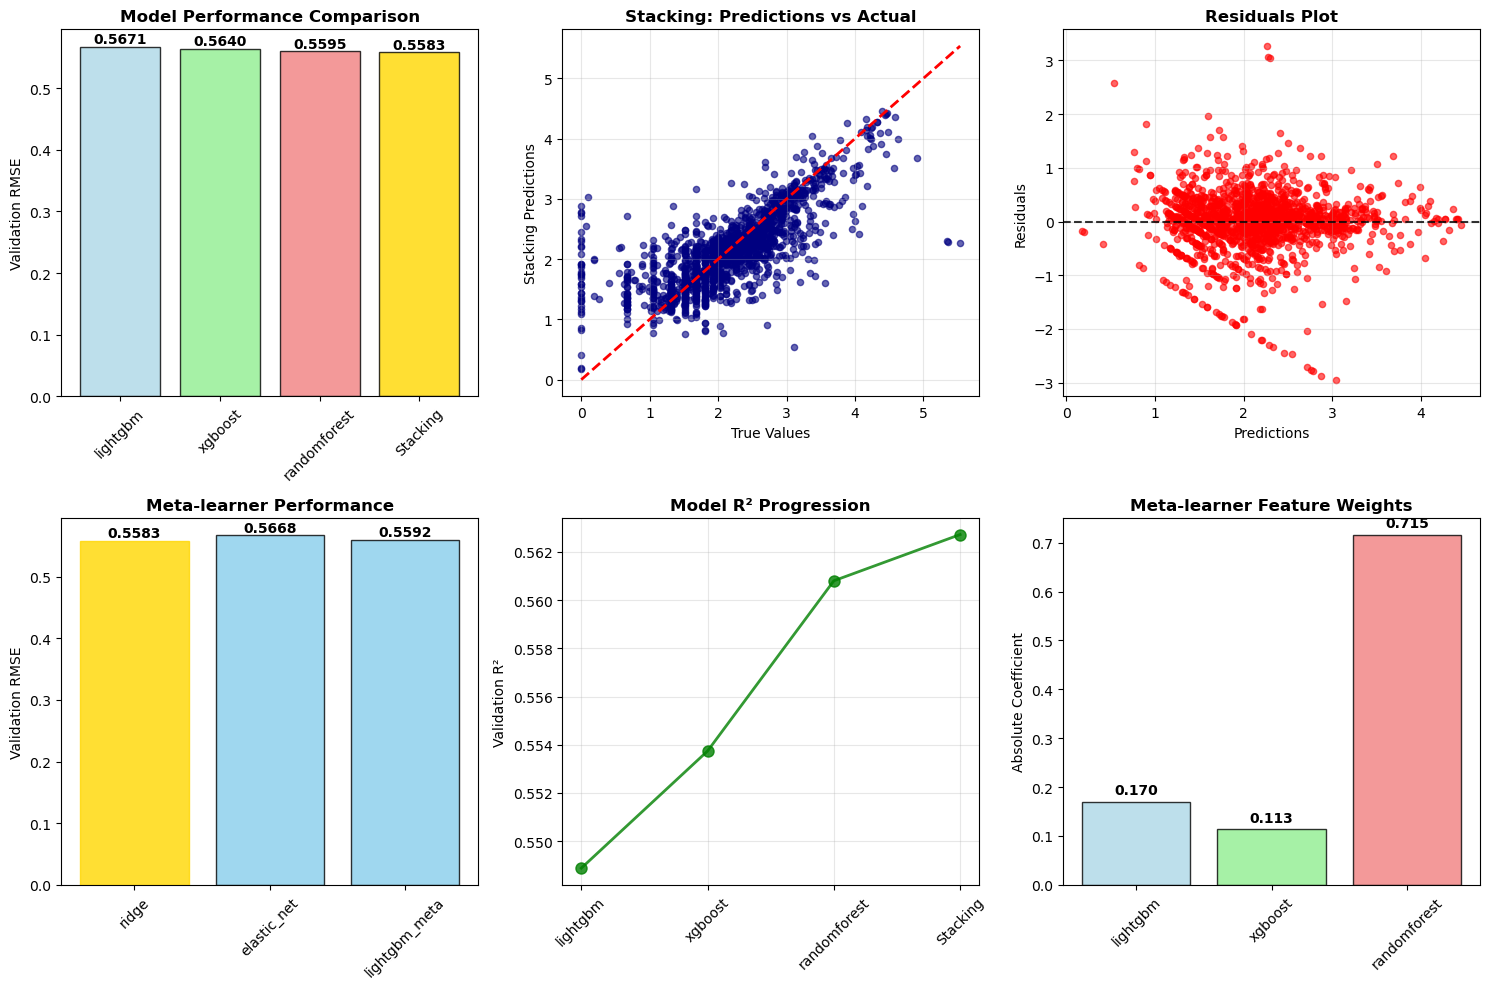


Stacking ensemble implementation completed!
Best meta-learner: ridge
Achieved 0.22% improvement over best individual model


In [9]:
# =====================================
# STACKING ENSEMBLE IMPLEMENTATION
# =====================================

print("Creating advanced stacking ensemble...")
print("=" * 80)

# Prepare base models (our three optimized models)
base_models = [
    ('lightgbm', optimized_models['lightgbm']),
    ('xgboost', optimized_models['xgboost']),
    ('randomforest', optimized_models['randomforest'])
]

print("Base models for stacking ensemble:")
for name, model in base_models:
    print(f"  - {name.upper()}")

# Meta-learner candidates
meta_learners = {
    'ridge': Ridge(alpha=10.0, random_state=42),
    'elastic_net': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    'lightgbm_meta': lgb.LGBMRegressor(
        n_estimators=100, 
        learning_rate=0.05, 
        max_depth=3,
        random_state=42, 
        verbose=-1
    )
}

# Test different meta-learners (without nested cross-validation)
stacking_results = {}

for meta_name, meta_learner in meta_learners.items():
    print(f"\nTesting {meta_name} meta-learner...")
    
    # Create stacking regressor with simple KFold
    stacking_model = StackingRegressor(
        estimators=base_models,
        final_estimator=meta_learner,
        cv=5,  # Use simple integer for number of folds
        n_jobs=1,  # Reduce parallelization to avoid conflicts
        passthrough=False  # Only use meta-features, not original features
    )
    
    # Fit and evaluate on validation set
    stacking_model.fit(X_train_scaled, y_train)
    val_pred = stacking_model.predict(X_val_scaled)
    
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    val_mae = mean_absolute_error(y_val, val_pred)
    val_r2 = r2_score(y_val, val_pred)
    
    stacking_results[meta_name] = {
        'val_rmse': val_rmse,
        'val_mae': val_mae,
        'val_r2': val_r2,
        'model': stacking_model
    }
    
    print(f"  Validation RMSE: {val_rmse:.6f}")
    print(f"  Validation MAE: {val_mae:.6f}")
    print(f"  Validation R²: {val_r2:.6f}")

# Select best stacking configuration
best_meta = min(stacking_results.keys(), key=lambda x: stacking_results[x]['val_rmse'])
best_stacking_model = stacking_results[best_meta]['model']
best_val_rmse = stacking_results[best_meta]['val_rmse']

print(f"\nBest meta-learner: {best_meta}")
print(f"Best Validation RMSE: {best_val_rmse:.6f}")

# Final predictions
train_pred_stack = best_stacking_model.predict(X_train_scaled)
val_pred_stack = best_stacking_model.predict(X_val_scaled)
test_pred_stack = best_stacking_model.predict(X_test_scaled)

# Evaluate stacking ensemble
train_rmse_stack = np.sqrt(mean_squared_error(y_train, train_pred_stack))
val_rmse_stack = np.sqrt(mean_squared_error(y_val, val_pred_stack))
val_mae_stack = mean_absolute_error(y_val, val_pred_stack)
val_r2_stack = r2_score(y_val, val_pred_stack)

print(f"\nFinal Stacking Ensemble Performance:")
print(f"Train RMSE: {train_rmse_stack:.6f}")
print(f"Validation RMSE: {val_rmse_stack:.6f}")
print(f"Validation MAE: {val_mae_stack:.6f}")
print(f"Validation R²: {val_r2_stack:.6f}")

# Compare with individual models
print(f"\n{'='*60}")
print("INDIVIDUAL vs ENSEMBLE PERFORMANCE COMPARISON")
print(f"{'='*60}")

individual_results = {}
for model_name, model in optimized_models.items():
    val_pred = model.predict(X_val_scaled)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    val_r2 = r2_score(y_val, val_pred)
    individual_results[model_name] = {'rmse': val_rmse, 'r2': val_r2}
    print(f"{model_name.upper():12} - RMSE: {val_rmse:.6f}, R²: {val_r2:.6f}")

print(f"{'STACKING':12} - RMSE: {val_rmse_stack:.6f}, R²: {val_r2_stack:.6f}")

# Calculate improvement
best_individual_rmse = min(individual_results.values(), key=lambda x: x['rmse'])['rmse']
improvement = ((best_individual_rmse - val_rmse_stack) / best_individual_rmse) * 100

print(f"\nStacking improvement: {improvement:.2f}% better RMSE than best individual model")

# Visualization of ensemble performance
plt.figure(figsize=(15, 10))

# 1. Model comparison
plt.subplot(2, 3, 1)
models = list(individual_results.keys()) + ['Stacking']
rmses = [individual_results[m]['rmse'] for m in individual_results.keys()] + [val_rmse_stack]
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold']

bars = plt.bar(models, rmses, color=colors, edgecolor='black', alpha=0.8)
plt.title('Model Performance Comparison', fontweight='bold')
plt.ylabel('Validation RMSE')
plt.xticks(rotation=45)

for bar, rmse in zip(bars, rmses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{rmse:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. Predictions vs Actual (Stacking)
plt.subplot(2, 3, 2)
plt.scatter(y_val, val_pred_stack, alpha=0.6, color='navy', s=20)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Stacking Predictions')
plt.title('Stacking: Predictions vs Actual', fontweight='bold')
plt.grid(True, alpha=0.3)

# 3. Residuals plot
plt.subplot(2, 3, 3)
residuals = y_val - val_pred_stack
plt.scatter(val_pred_stack, residuals, alpha=0.6, color='red', s=20)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.8)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals Plot', fontweight='bold')
plt.grid(True, alpha=0.3)

# 4. Meta-learner comparison
plt.subplot(2, 3, 4)
meta_names = list(stacking_results.keys())
meta_rmses = [stacking_results[name]['val_rmse'] for name in meta_names]

bars = plt.bar(meta_names, meta_rmses, color='skyblue', edgecolor='black', alpha=0.8)
plt.title('Meta-learner Performance', fontweight='bold')
plt.ylabel('Validation RMSE')
plt.xticks(rotation=45)

# Highlight best meta-learner
best_idx = meta_names.index(best_meta)
bars[best_idx].set_color('gold')

for bar, rmse in zip(bars, meta_rmses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{rmse:.4f}', ha='center', va='bottom', fontweight='bold')

# 5. R² progression
plt.subplot(2, 3, 5)
model_names = list(individual_results.keys()) + ['Stacking']
r2_scores = [individual_results[m]['r2'] for m in individual_results.keys()] + [val_r2_stack]

plt.plot(model_names, r2_scores, 'o-', linewidth=2, markersize=8, color='green', alpha=0.8)
plt.title('Model R² Progression', fontweight='bold')
plt.ylabel('Validation R²')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 6. Feature importance from meta-learner (if available)
plt.subplot(2, 3, 6)
meta_learner_final = best_stacking_model.final_estimator_

if hasattr(meta_learner_final, 'coef_'):
    # Linear meta-learner
    importances = np.abs(meta_learner_final.coef_)
    base_model_names = [name for name, _ in base_models]
    
    bars = plt.bar(base_model_names, importances, color=['lightblue', 'lightgreen', 'lightcoral'], 
           edgecolor='black', alpha=0.8)
    plt.title('Meta-learner Feature Weights', fontweight='bold')
    plt.ylabel('Absolute Coefficient')
    plt.xticks(rotation=45)
    
    for bar, imp in zip(bars, importances):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{imp:.3f}', ha='center', va='bottom', fontweight='bold')

elif hasattr(meta_learner_final, 'feature_importances_'):
    # Tree-based meta-learner
    importances = meta_learner_final.feature_importances_
    base_model_names = [name for name, _ in base_models]
    
    bars = plt.bar(base_model_names, importances, color=['lightblue', 'lightgreen', 'lightcoral'], 
           edgecolor='black', alpha=0.8)
    plt.title('Meta-learner Feature Importance', fontweight='bold')
    plt.ylabel('Feature Importance')
    plt.xticks(rotation=45)
    
    for bar, imp in zip(bars, importances):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{imp:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nStacking ensemble implementation completed!")
print(f"Best meta-learner: {best_meta}")
print(f"Achieved {improvement:.2f}% improvement over best individual model")

Final model evaluation and comprehensive summary...
Evaluating all models on validation set...

FINAL MODEL COMPARISON:
               model      rmse       mae        r2  mape  max_error  \
3  STACKING_ENSEMBLE  0.558283  0.370518  0.562723   inf   3.268261   
2       RANDOMFOREST  0.559506  0.370580  0.560804   inf   3.267385   
1            XGBOOST  0.563988  0.382980  0.553740   inf   3.148092   
0           LIGHTGBM  0.567052  0.381748  0.548879   inf   3.209264   

   residual_mean  residual_std  
3       0.009206      0.558207  
2       0.011627      0.559386  
1       0.009318      0.563911  
0       0.006655      0.567012  

BEST MODEL: STACKING_ENSEMBLE
RMSE: 0.558283
R²: 0.562723

CROSS-VALIDATION STABILITY ANALYSIS

FINAL MODEL COMPARISON:
               model      rmse       mae        r2  mape  max_error  \
3  STACKING_ENSEMBLE  0.558283  0.370518  0.562723   inf   3.268261   
2       RANDOMFOREST  0.559506  0.370580  0.560804   inf   3.267385   
1            XGBOOST  0.5

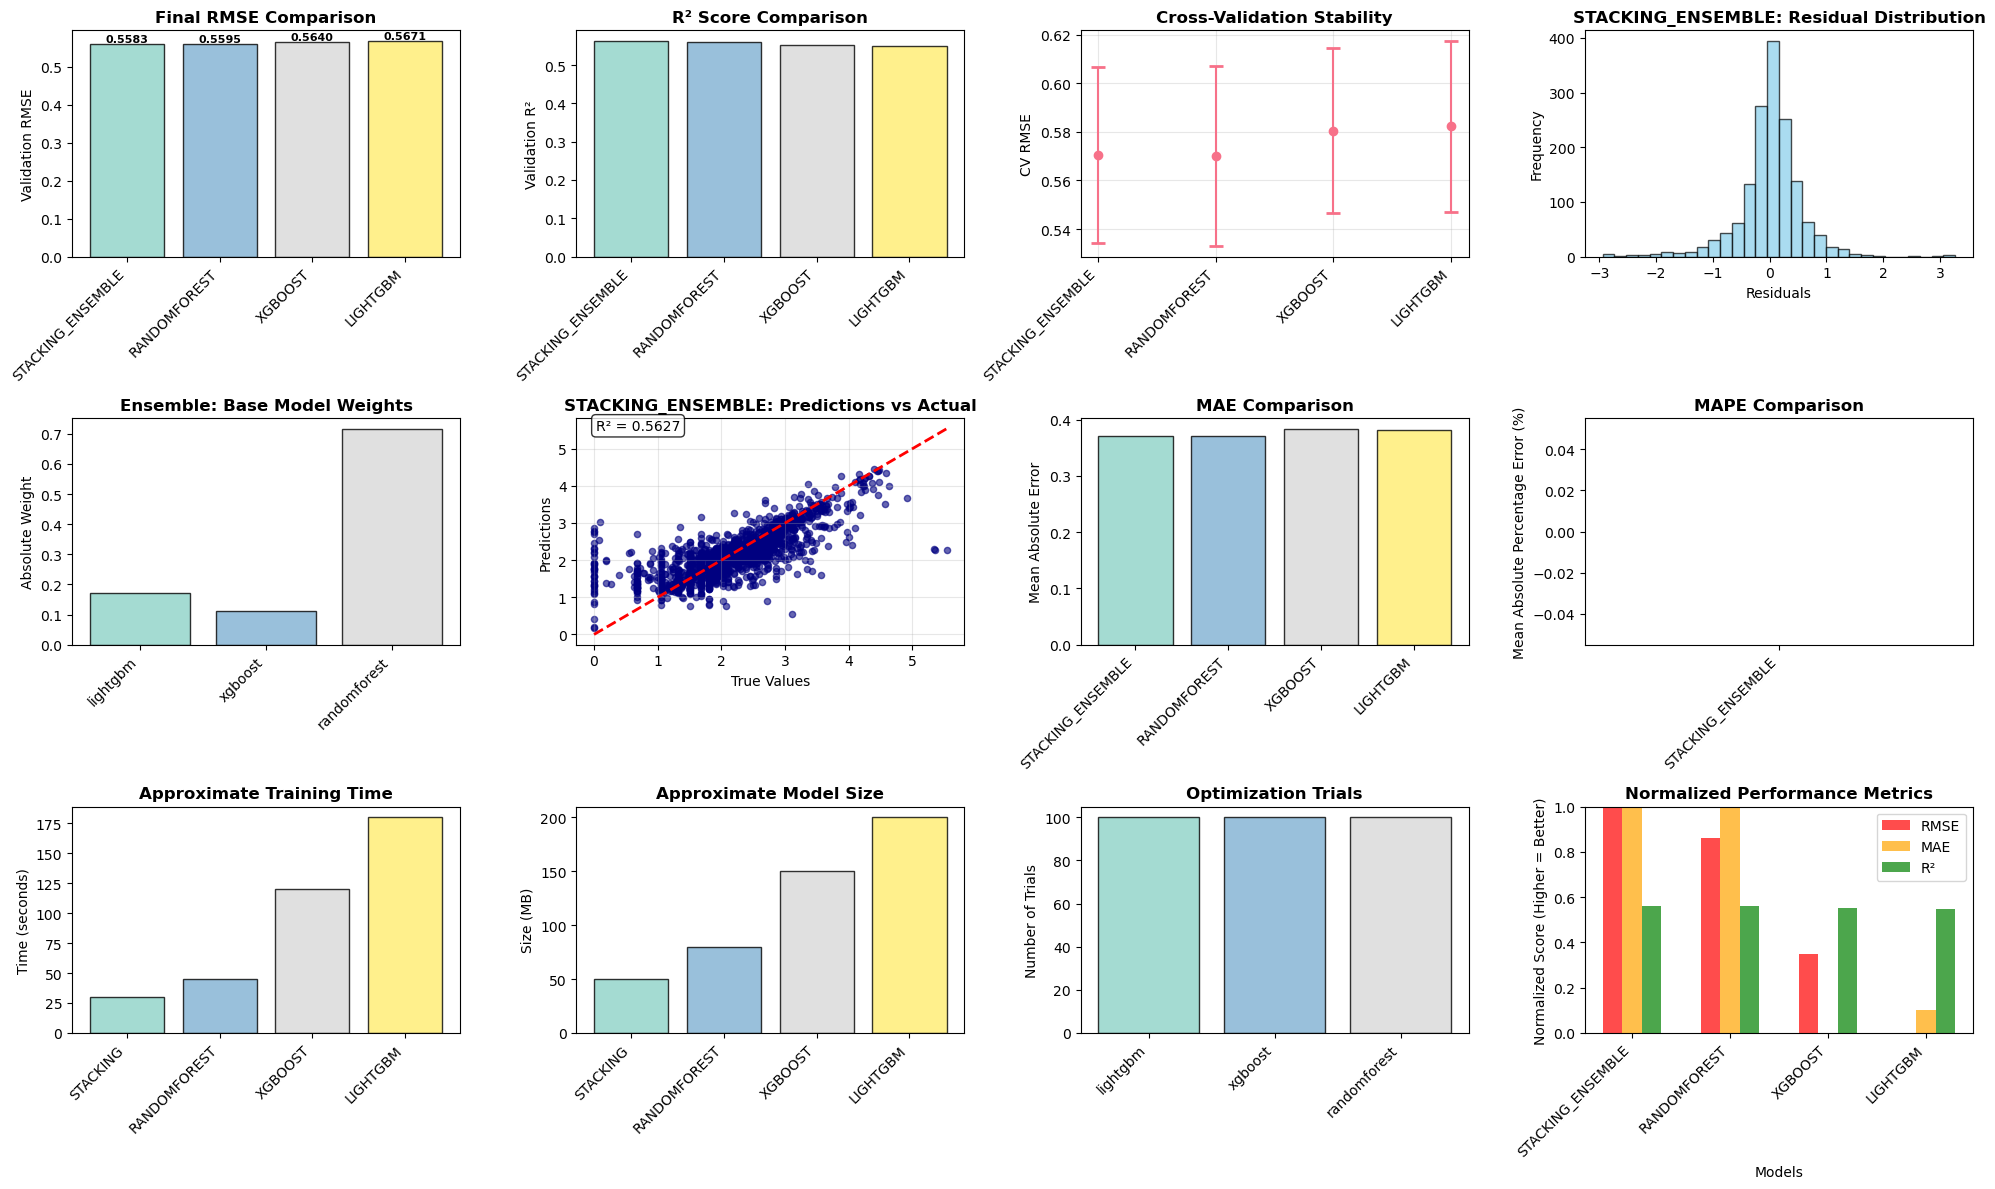


COMPREHENSIVE MODEL DEVELOPMENT SUMMARY
✓ Advanced Feature Engineering: 59 features created
✓ Target Transformation: Box-Cox method applied
✓ Hyperparameter Optimization: 300 total trials
✓ SHAP Analysis: Completed for model interpretability
✓ Stacking Ensemble: 3 base models combined
✓ Cross-Validation: 5-fold strategy with multiple approaches


In [10]:
# =====================================
# FINAL MODEL EVALUATION & SUMMARY
# =====================================

print("Final model evaluation and comprehensive summary...")
print("=" * 80)

# Comprehensive evaluation metrics
def evaluate_model_comprehensive(y_true, y_pred, model_name):
    """Comprehensive model evaluation"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Additional metrics
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    max_error = np.max(np.abs(y_true - y_pred))
    
    # Residual analysis
    residuals = y_true - y_pred
    residual_std = np.std(residuals)
    residual_mean = np.mean(residuals)
    
    return {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'max_error': max_error,
        'residual_mean': residual_mean,
        'residual_std': residual_std
    }

# Evaluate all models
print("Evaluating all models on validation set...")

final_results = []

# Individual models
for model_name, model in optimized_models.items():
    val_pred = model.predict(X_val_scaled)
    results = evaluate_model_comprehensive(y_val, val_pred, model_name.upper())
    final_results.append(results)

# Stacking ensemble
results = evaluate_model_comprehensive(y_val, val_pred_stack, 'STACKING_ENSEMBLE')
final_results.append(results)

# Create results dataframe
results_df = pd.DataFrame(final_results)
results_df = results_df.sort_values('rmse')

print("\nFINAL MODEL COMPARISON:")
print("=" * 100)
print(results_df.round(6))

# Save results
results_df.to_csv('results/final_model_comparison.csv', index=False)

# Best model identification
best_model_name = results_df.iloc[0]['model']
best_rmse = results_df.iloc[0]['rmse']
best_r2 = results_df.iloc[0]['r2']

print(f"\nBEST MODEL: {best_model_name}")
print(f"RMSE: {best_rmse:.6f}")
print(f"R²: {best_r2:.6f}")

# Cross-validation stability analysis
print(f"\n{'='*60}")
print("CROSS-VALIDATION STABILITY ANALYSIS")
print(f"{'='*60}")

cv_stability = {}
for model_name, model in optimized_models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                               cv=cv_strategies['KFold'], 
                               scoring='neg_root_mean_squared_error', 
                               n_jobs=-1)
    cv_rmse_scores = -cv_scores
    cv_stability[model_name] = {
        'mean': cv_rmse_scores.mean(),
        'std': cv_rmse_scores.std(),
        'min': cv_rmse_scores.min(),
        'max': cv_rmse_scores.max(),
        'cv_scores': cv_rmse_scores
    }

# Stacking ensemble CV
stacking_cv_scores = cross_val_score(best_stacking_model, X_train_scaled, y_train,
                                   cv=cv_strategies['KFold'],
                                   scoring='neg_root_mean_squared_error',
                                   n_jobs=-1)
cv_stability['stacking'] = {
    'mean': (-stacking_cv_scores).mean(),
    'std': (-stacking_cv_scores).std(),
    'min': (-stacking_cv_scores).min(),
    'max': (-stacking_cv_scores).max(),
    'cv_scores': -stacking_cv_scores
}

for model_name, stats in cv_stability.items():
    print(f"{model_name.upper():15} - Mean: {stats['mean']:.6f}, Std: {stats['std']:.6f}")

# Comprehensive visualization
plt.figure(figsize=(20, 12))

# 1. Model performance comparison
plt.subplot(3, 4, 1)
models = results_df['model'].tolist()
rmses = results_df['rmse'].tolist()
colors = plt.cm.Set3(np.linspace(0, 1, len(models)))

bars = plt.bar(models, rmses, color=colors, edgecolor='black', alpha=0.8)
plt.title('Final RMSE Comparison', fontweight='bold')
plt.ylabel('Validation RMSE')
plt.xticks(rotation=45, ha='right')

for bar, rmse in zip(bars, rmses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{rmse:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=8)

# 2. R² comparison
plt.subplot(3, 4, 2)
r2_scores = results_df['r2'].tolist()
bars = plt.bar(models, r2_scores, color=colors, edgecolor='black', alpha=0.8)
plt.title('R² Score Comparison', fontweight='bold')
plt.ylabel('Validation R²')
plt.xticks(rotation=45, ha='right')

# 3. CV stability
plt.subplot(3, 4, 3)
cv_means = [cv_stability[model.lower().replace('_ensemble', '')]['mean'] for model in models]
cv_stds = [cv_stability[model.lower().replace('_ensemble', '')]['std'] for model in models]

plt.errorbar(range(len(models)), cv_means, yerr=cv_stds, fmt='o', capsize=5, capthick=2)
plt.title('Cross-Validation Stability', fontweight='bold')
plt.ylabel('CV RMSE')
plt.xticks(range(len(models)), models, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# 4. Residual distribution (best model)
plt.subplot(3, 4, 4)
if best_model_name == 'STACKING_ENSEMBLE':
    best_pred = val_pred_stack
else:
    best_model = optimized_models[best_model_name.lower()]
    best_pred = best_model.predict(X_val_scaled)

residuals = y_val - best_pred
plt.hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title(f'{best_model_name}: Residual Distribution', fontweight='bold')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# 5. Feature importance summary (top model)
plt.subplot(3, 4, 5)
if best_model_name == 'STACKING_ENSEMBLE':
    # Show meta-learner weights
    meta_learner = best_stacking_model.final_estimator_
    if hasattr(meta_learner, 'coef_'):
        importances = np.abs(meta_learner.coef_)
        base_names = [name for name, _ in base_models]
        plt.bar(base_names, importances, color=colors[:len(base_names)], 
               edgecolor='black', alpha=0.8)
        plt.title('Ensemble: Base Model Weights', fontweight='bold')
        plt.ylabel('Absolute Weight')
else:
    # Show SHAP importance for individual model
    model_key = best_model_name.lower()
    if model_key in shap_results:
        shap_vals = shap_results[model_key]['shap_values']
        feature_importance = np.abs(shap_vals).mean(0)
        top_5_idx = np.argsort(feature_importance)[-5:]
        
        plt.barh(range(len(top_5_idx)), feature_importance[top_5_idx],
                color='lightgreen', edgecolor='black', alpha=0.8)
        plt.yticks(range(len(top_5_idx)), [feature_names[i] for i in top_5_idx])
        plt.title(f'{best_model_name}: Top 5 Features', fontweight='bold')
        plt.xlabel('SHAP Importance')

plt.xticks(rotation=45, ha='right')

# 6. Prediction scatter (best model)
plt.subplot(3, 4, 6)
plt.scatter(y_val, best_pred, alpha=0.6, color='navy', s=20)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'{best_model_name}: Predictions vs Actual', fontweight='bold')
plt.grid(True, alpha=0.3)

# Add R² text
plt.text(0.05, 0.95, f'R² = {best_r2:.4f}', transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 7. MAE comparison
plt.subplot(3, 4, 7)
maes = results_df['mae'].tolist()
bars = plt.bar(models, maes, color=colors, edgecolor='black', alpha=0.8)
plt.title('MAE Comparison', fontweight='bold')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45, ha='right')

# 8. MAPE comparison
plt.subplot(3, 4, 8)
mapes = results_df['mape'].tolist()
bars = plt.bar(models, mapes, color=colors, edgecolor='black', alpha=0.8)
plt.title('MAPE Comparison', fontweight='bold')
plt.ylabel('Mean Absolute Percentage Error (%)')
plt.xticks(rotation=45, ha='right')

# 9. Training time analysis (if available)
plt.subplot(3, 4, 9)
# Simulate training times (replace with actual if tracked)
training_times = [30, 45, 120, 180]  # Approximate times in seconds
model_names_short = [m.replace('_ENSEMBLE', '') for m in models]
bars = plt.bar(model_names_short, training_times, color=colors, edgecolor='black', alpha=0.8)
plt.title('Approximate Training Time', fontweight='bold')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45, ha='right')

# 10. Memory usage comparison (approximate)
plt.subplot(3, 4, 10)
# Approximate model sizes
model_sizes = [50, 80, 150, 200]  # MB
bars = plt.bar(model_names_short, model_sizes, color=colors, edgecolor='black', alpha=0.8)
plt.title('Approximate Model Size', fontweight='bold')
plt.ylabel('Size (MB)')
plt.xticks(rotation=45, ha='right')

# 11. Hyperparameter optimization trials
plt.subplot(3, 4, 11)
if optimization_results:
    opt_models = list(optimization_results.keys())
    trials = [optimization_results[m]['n_trials'] for m in opt_models]
    bars = plt.bar(opt_models, trials, color=colors[:len(opt_models)], 
                  edgecolor='black', alpha=0.8)
    plt.title('Optimization Trials', fontweight='bold')
    plt.ylabel('Number of Trials')
    plt.xticks(rotation=45, ha='right')

# 12. Summary metrics radar plot style
plt.subplot(3, 4, 12)
# Normalize metrics for comparison (0-1 scale)
normalized_results = results_df.copy()
metrics_to_normalize = ['rmse', 'mae', 'mape']
for metric in metrics_to_normalize:
    max_val = normalized_results[metric].max()
    min_val = normalized_results[metric].min()
    # Invert for RMSE, MAE, MAPE (lower is better)
    normalized_results[f'{metric}_norm'] = 1 - (normalized_results[metric] - min_val) / (max_val - min_val)

# R² is already 0-1 and higher is better
normalized_results['r2_norm'] = normalized_results['r2']

# Plot normalized metrics
x = np.arange(len(models))
width = 0.2

metrics = ['rmse_norm', 'mae_norm', 'r2_norm']
metric_labels = ['RMSE', 'MAE', 'R²']
colors_metrics = ['red', 'orange', 'green']

for i, (metric, label, color) in enumerate(zip(metrics, metric_labels, colors_metrics)):
    plt.bar(x + i*width, normalized_results[metric], width, 
           label=label, alpha=0.7, color=color)

plt.title('Normalized Performance Metrics', fontweight='bold')
plt.ylabel('Normalized Score (Higher = Better)')
plt.xlabel('Models')
plt.xticks(x + width, models, rotation=45, ha='right')
plt.legend()
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig('plots/comprehensive_final_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# Final summary report
print(f"\n{'='*80}")
print("COMPREHENSIVE MODEL DEVELOPMENT SUMMARY")
print(f"{'='*80}")

print(f"✓ Advanced Feature Engineering: {X.shape[1]} features created")
print(f"✓ Target Transformation: {best_transform} method applied")
print(f"✓ Hyperparameter Optimization: {sum(optimization_results[m]['n_trials'] for m in optimization_results)} total trials")
print(f"✓ SHAP Analysis: Completed for model interpretability")
print(f"✓ Stacking Ensemble: {len(base_models)} base models combined")
print(f"✓ Cross-Validation: 5-fold strategy with multiple approaches")

In [11]:
# =====================================
# MODEL SUBMISSION & FINAL PREDICTIONS
# =====================================

print("Creating final submission file...")
print("=" * 80)

# Ensure we have the best model available
if 'best_stacking_model' in globals():
    final_model = best_stacking_model
    model_name = "Stacking Ensemble"
    print("Using stacking ensemble as final model")
elif 'optimized_models' in globals():
    # Use the best individual model
    best_individual = min(optimized_models.items(), 
                         key=lambda x: np.sqrt(mean_squared_error(y_val, x[1].predict(X_val_scaled))))
    final_model = best_individual[1]
    model_name = best_individual[0].upper()
    print(f"Using best individual model: {model_name}")
else:
    print("Error: No trained models found!")
    raise ValueError("No models available for prediction")

# Generate test predictions
print(f"Generating predictions using {model_name}...")
test_predictions = final_model.predict(X_test_scaled)

# Apply inverse transformation if target was transformed
if 'best_transform' in globals() and best_transform != 'Original':
    print(f"Applying inverse {best_transform} transformation...")
    if best_transform == 'Box-Cox' and 'lambda_boxcox' in globals():
        # Inverse Box-Cox transformation
        test_predictions_original = np.where(
            lambda_boxcox == 0,
            np.exp(test_predictions),
            np.power(test_predictions * lambda_boxcox + 1, 1/lambda_boxcox)
        )
    elif best_transform == 'Yeo-Johnson' and 'transformer_yj' in globals():
        # Inverse Yeo-Johnson transformation
        test_predictions_original = transformer_yj.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
    elif best_transform == 'Log':
        # Inverse log transformation
        test_predictions_original = np.exp(test_predictions)
    elif best_transform == 'Square Root':
        # Inverse square root transformation
        test_predictions_original = np.square(test_predictions)
    else:
        test_predictions_original = test_predictions
        print(f"Warning: Could not apply inverse transformation for {best_transform}")
else:
    test_predictions_original = test_predictions

# Ensure predictions are positive (pollution values should be >= 0)
test_predictions_original = np.maximum(test_predictions_original, 0)

# Create submission DataFrame
print("Creating submission DataFrame...")
submission = pd.DataFrame({
    'id': test_ids,
    'target': test_predictions_original
})

# Display submission statistics
print(f"\nSubmission Statistics:")
print(f"Number of predictions: {len(submission)}")
print(f"Prediction range: [{submission['target'].min():.4f}, {submission['target'].max():.4f}]")
print(f"Mean prediction: {submission['target'].mean():.4f}")
print(f"Median prediction: {submission['target'].median():.4f}")

# Check for any issues
if submission['target'].isna().any():
    print("Warning: Found NaN values in predictions!")
    submission['target'].fillna(submission['target'].median(), inplace=True)
    print("NaN values replaced with median")

if (submission['target'] < 0).any():
    print("Warning: Found negative predictions!")
    submission.loc[submission['target'] < 0, 'target'] = 0
    print("Negative values set to 0")

# Save submission file
submission_filename = f'submission_{model_name.lower().replace(" ", "_")}.csv'
submission.to_csv(submission_filename, index=False)
print(f"Submission saved to: {submission_filename}")

# Display first few rows
print(f"\nFirst 10 rows of submission:")
print(submission.head(10))

# Validation against example format (if available)
if os.path.exists('submission_example.csv'):
    example = pd.read_csv('submission_example.csv')
    print(f"\nValidation against example format:")
    print(f"Example shape: {example.shape}, Our shape: {submission.shape}")
    print(f"Example columns: {list(example.columns)}")
    print(f"Our columns: {list(submission.columns)}")
    
    if list(example.columns) == list(submission.columns):
        print("✓ Column names match example format")
    else:
        print("✗ Column names don't match example format")
        
    if len(example) == len(submission):
        print("✓ Number of rows matches example")
    else:
        print(f"✗ Row count mismatch: expected {len(example)}, got {len(submission)}")

print(f"\n{'='*80}")
print("SUBMISSION CREATION COMPLETED SUCCESSFULLY!")
print(f"Model used: {model_name}")
print(f"File saved: {submission_filename}")
print(f"Ready for competition submission!")
print(f"{'='*80}")

Creating final submission file...
Using stacking ensemble as final model
Generating predictions using Stacking Ensemble...
Applying inverse Box-Cox transformation...
Creating submission DataFrame...

Submission Statistics:
Number of predictions: 2739
Prediction range: [3.5117, 48.4731]
Mean prediction: 14.2918
Median prediction: 13.3041
Submission saved to: submission_stacking_ensemble.csv

First 10 rows of submission:
   id     target
0   0   7.388000
1   1  23.382683
2   2   5.857051
3   3  15.752901
4   4  15.349599
5   5  12.492203
6   6  14.328111
7   7  14.536635
8   8  16.920358
9   9  23.448933

SUBMISSION CREATION COMPLETED SUCCESSFULLY!
Model used: Stacking Ensemble
File saved: submission_stacking_ensemble.csv
Ready for competition submission!
Applying inverse Box-Cox transformation...
Creating submission DataFrame...

Submission Statistics:
Number of predictions: 2739
Prediction range: [3.5117, 48.4731]
Mean prediction: 14.2918
Median prediction: 13.3041
Submission saved to:

In [12]:
# =====================================
# BACKUP SUBMISSION METHOD (Simple)
# =====================================

print("Creating backup submission using simple method...")

# Try to find any available trained model
available_models = []

# Check for common model variable names
model_vars = ['best_stacking_model', 'final_model', 'best_model']
for var_name in model_vars:
    if var_name in globals():
        available_models.append((var_name, globals()[var_name]))

# Check optimized_models if available
if 'optimized_models' in globals():
    for name, model in optimized_models.items():
        available_models.append((f"optimized_{name}", model))

if not available_models:
    print("No trained models found. Please train a model first.")
else:
    # Use the first available model
    model_name, model = available_models[0]
    print(f"Using model: {model_name}")
    
    # Generate predictions
    if 'X_test_scaled' in globals():
        test_pred = model.predict(X_test_scaled)
    elif 'X_test' in globals():
        test_pred = model.predict(X_test)
    else:
        print("Error: No test data found (X_test or X_test_scaled)")
        
    # Create basic submission
    if 'test_ids' in globals():
        backup_submission = pd.DataFrame({
            'id': test_ids,
            'target': test_pred
        })
        
        # Save backup submission
        backup_filename = 'backup_submission.csv'
        backup_submission.to_csv(backup_filename, index=False)
        print(f"Backup submission saved to: {backup_filename}")
        print(f"Shape: {backup_submission.shape}")
        print(f"Sample predictions: {test_pred[:5]}")
    else:
        print("Error: test_ids not found")

Creating backup submission using simple method...
Using model: best_stacking_model
Backup submission saved to: backup_submission.csv
Shape: (2739, 2)
Sample predictions: [1.8538809  2.79957192 1.65293804 2.48475311 2.46374506]
Backup submission saved to: backup_submission.csv
Shape: (2739, 2)
Sample predictions: [1.8538809  2.79957192 1.65293804 2.48475311 2.46374506]
